# Learning parameters in a differentiable Lorenz 63 model

So here I go. I am not sure if this is completely stupid or trivial but it's something I have been wondering about for a while now. So I am just putting this out there in hope that someone much more clever tells me that it's a dumb idea.

The idea is that some Python libraries (here I am using PyTorch) now have automatic differentiation which allow us to compute gradients of a loss (=cost) function with respect to model parameters. This is the backbone of how neural nets work. 

In climate and weather modeling there are many uncertain parameters, which are usually hand-tuned. This is error-prone and unefficient in high-dimensional parameter spaces. 

So here is my idea. Could we write our "weather" model in PyTorch and improve the parameters using gradient descent?

I will use the simplest non-linear model I know, the Lorenz '63 three-variable model, which still exhibits chaotic behaviour. The more comple Lorenz 96 model probably would be a more realistic choice, but I didn't have time yet to figure it out.

Here are the equations:

$\frac{dx}{dt} = \sigma (y-x)$

$\frac{dy}{dt} = x (\rho - z) -y$

$\frac{dz}{dt} = xy - \beta z$

We will try to learn the parameters $\sigma, \rho, \beta$.

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from torch.autograd import Variable
import tqdm
from collections import defaultdict

In [49]:
# Handy function stolen from the fast.ai library
def V(x, requires_grad=False, gpu=False):
    t = torch.FloatTensor(np.atleast_1d(x).astype(np.float32))
    if gpu: t = t.cuda()
    return Variable(t, requires_grad=requires_grad)

## Numpy implementation

Let's start out with a model class in Numpy. The model basically only does one thing: It steps forward one time step in the discretized version of above equations.

In [50]:
# Define the default parameters values
sigma = 10
rho = 28
beta = 8/3

In [51]:
class L63():
    def __init__(self, sigma, rho, beta, init, dt):
        self.sigma, self.rho, self.beta = sigma, rho, beta 
        self.x, self.y, self.z = init
        self.dt = dt
        self.hist = [init]
    
    def step(self):
        self.x += (self.sigma * (self.y - self.x)) * self.dt
        self.y += (self.x * (self.rho - self.z)) * self.dt
        self.z += (self.x * self.y - self.beta * self.z) * self.dt
        self.hist.append([self.x, self.y, self.z])
    
    def integrate(self, n_steps):
        for n in range(n_steps): self.step()

Let's now create two models with slightly different inital conditions so we can see the chaotic divergence.

In [52]:
l = L63(sigma, rho, beta, init=[1, 10, 20], dt=1e-2)

In [53]:
l.integrate(300)

In [54]:
l2 = L63(sigma, rho, beta, init=[1.1, 10, 20], dt=1e-2)

In [55]:
l2.integrate(300)

In [56]:
fig = plt.figure(figsize=(10, 10));


<Figure size 1000x1000 with 0 Axes>

In [57]:
def plot_attractor(hists):
    if np.array(hists).ndim == 2: hists = [hists]
    hists = [np.array(h) for h in hists]
    fig = plt.figure(figsize=(10, 10));  ax= fig.add_subplot(projection='3d')
    [ax.plot(h[:,0], h[:,1], h[:,2]) for h in hists]

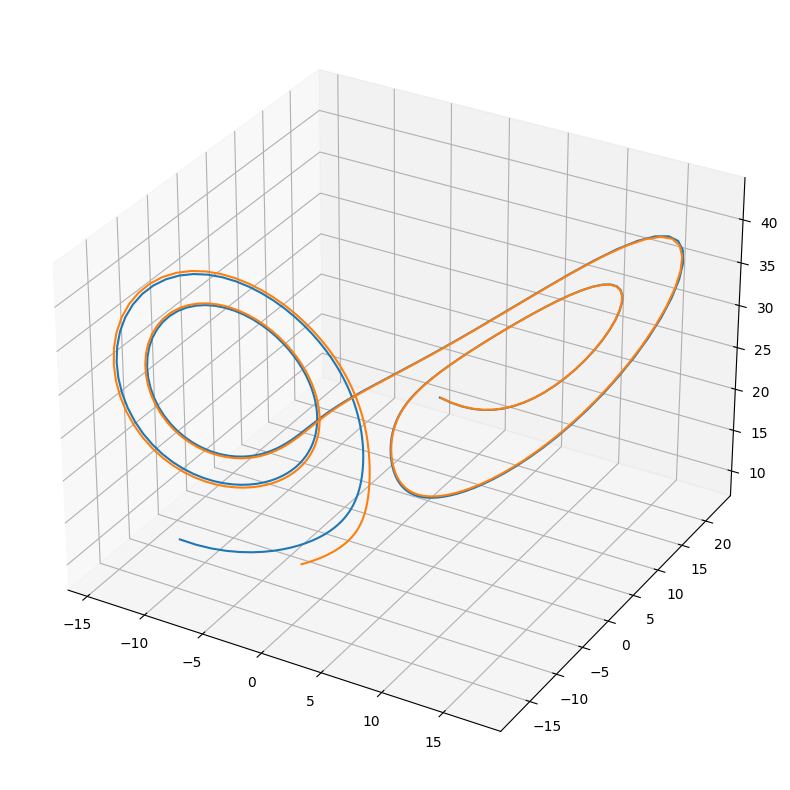

In [58]:
plot_attractor([l.hist, l2.hist])

So we can see that the lines diverge quite drastically after a while just as we would expect. CHAOS!

Oh yes, and I totally hand-picked the initial values to give me divergence early on...

## PyTorch implementation

Now let's do the same thing in PyTorch. For this we need to convert all variables to PyTorch Variables and tell PyTorch if we want to get the gradient for this variables later on.

In [59]:
class L63Torch():
    def __init__(self, sigma, rho, beta, init, dt, param_grads):
        self.sigma, self.rho, self.beta = [V(param, param_grads) for param in [sigma, rho, beta]]
        self.x, self.y, self.z = [V(i) for i in init]
        self.dt = V(dt)
        self.hist = []
        self.step_count = 0
    
    def step(self):
        self.x = self.x + (self.sigma * (self.y - self.x)) * self.dt
        self.y = self.y + (self.x * (self.rho - self.z)) * self.dt
        self.z = self.z + (self.x * self.y - self.beta * self.z) * self.dt
        self.hist.append(np.squeeze(np.array([np.copy(var.data.cpu().numpy()) for var in [self.x, self.y, self.z]])))
        self.step_count += 1
    
    def integrate(self, n_steps):
        for n in range(n_steps): self.step()

Let's see how this auto differentiation magic works. Let's first define a reference run, which is our "truth".

In [60]:
ltrue = L63Torch(sigma, rho, beta, init=[1, 10, 20], dt=1e-2, param_grads=False)

In [61]:
ltrue.integrate(200)

Now let's create a second model where we perturb the three parameters a little.

In [62]:
sigma, rho, beta

(10, 28, 2.6666666666666665)

In [63]:
lpert =  L63Torch(sigma + 0.5, rho - 1, beta - 0.2, init=[1, 10, 20], dt=1e-2, param_grads=True)

In [64]:
lpert.integrate(200)

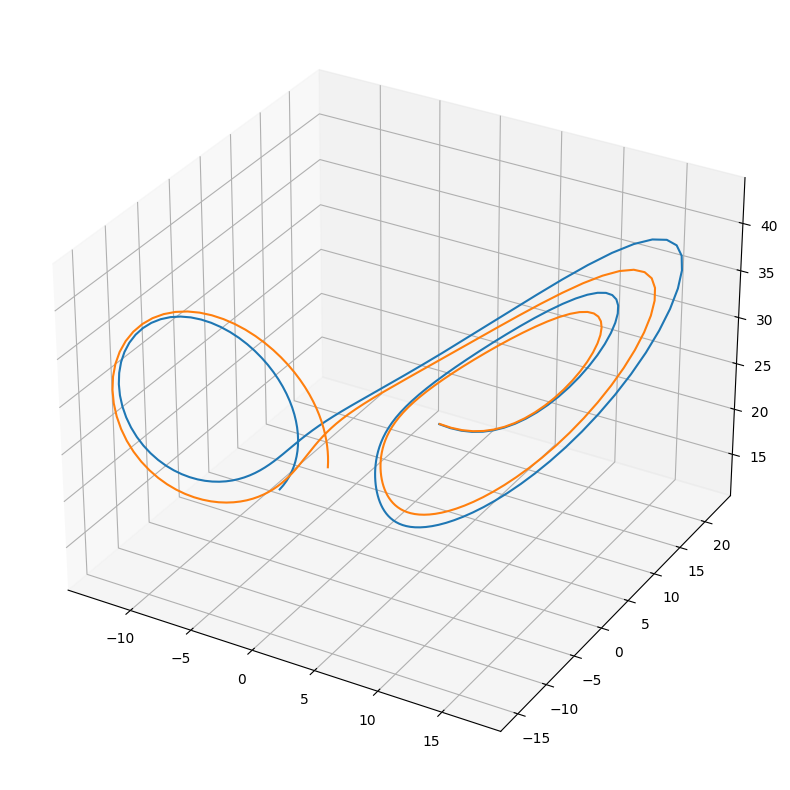

In [65]:
plot_attractor([ltrue.hist, lpert.hist])

Now the goal is to figure out how to bring the parameters of our perturbed model closer to the actual parameters. For this we will compute a loss/cost/error at time 200. We will simply use the mean squared error.

In [66]:
def mse(true, pred):
    return ((true - pred) ** 2).mean()

In [67]:
def stack_state(l, sparse=None):
    s = torch.stack([l.x, l.y, l.z])
    if sparse is not None: s = s[sparse]
    return s

In [68]:
loss = mse(stack_state(ltrue), stack_state(lpert))

In [69]:
loss

tensor(6.7381, grad_fn=<MeanBackward0>)

So this is our loss. Next we will take the gradient of the loss with respect to our three parameters. The gradients have been computed backwards for the entire time of our integration, in this case 200 time steps.

In [70]:
loss.backward()

In [71]:
lpert.sigma.grad

tensor([1.8991])

In [72]:
lpert.rho, ltrue.rho

(tensor([27.], requires_grad=True), tensor([28.]))

In [73]:
lpert.sigma.grad, lpert.rho.grad, lpert.beta.grad

(tensor([1.8991]), tensor([-14.0145]), tensor([16.8179]))

Now we can take a step down the gradient for each parameter to hopefully reduce the loss. We will take little steps at a time, the size of which is determined by the learning rate. 

Looking at the gradients above we can see that the first two are pointing in the correct direction (compare our pertubations) while the third is pointing in the wrong direction. This will be inevitable. Not every step is going to improve every parameter every time but the hope is that by repeating this process we will get closer to the truth eventually. 

Plus, the longer out integration time is, the harder it will be to get the correct gradients. We will look at this further below.

## Learning parameters iteratively

Now we will write a loop where each time we start a new truth and perturbed run, integrate for a while, get the gradients, take a step down the gradients and then start the next iteration with the updated parameters.

In [74]:
hist

defaultdict(list, {})

In [85]:
def learning_loop(true_params, pert_params, lr, n_model_steps, n_learn_steps, sparse=None):
    hist = defaultdict(list)
    init = list(np.random.rand(3) * 10)
    for n_learn in tqdm.notebook.tqdm(range(n_learn_steps)):
        ltrue = L63Torch(*true_params, init, 1e-2, False); ltrue.integrate(n_model_steps)
        lpert = L63Torch(*pert_params, init, 1e-2, True); lpert.integrate(n_model_steps)
        loss = mse(stack_state(ltrue, sparse), stack_state(lpert, sparse))
        loss.backward()
        grads = [lpert.sigma.grad.data.numpy(), lpert.rho.grad.data.numpy(), lpert.beta.grad.data.numpy()]
        pert_params = [pert_params[i] - lr*var.grad.data.numpy() for i, var in
                      enumerate([lpert.sigma, lpert.rho, lpert.beta])]
        hist['loss'].append(loss.data.numpy()); hist['pert_params'].append(pert_params)
        # init = ltrue.hist[-1]
    return hist

Now let's chose some inital perturbed parameters and run the learning loop for 300 iterations, each time integrating the models for 50 time steps.

In [97]:
true_params = [sigma, rho, beta]
pert_params = [sigma + 4, rho - 5, beta - 3]

In [109]:
h = learning_loop(true_params, pert_params, 1e-2, 50, 1200)

  0%|          | 0/1200 [00:00<?, ?it/s]

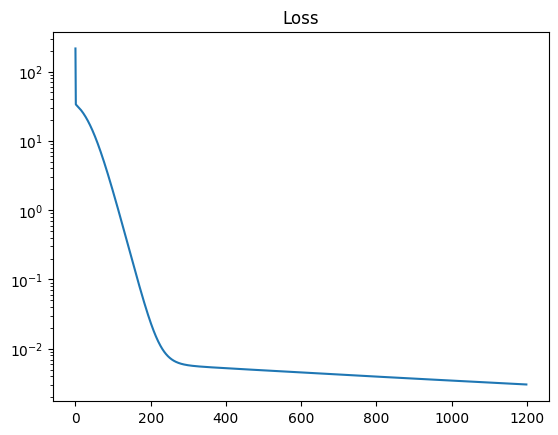

In [110]:
plt.plot(h['loss']); plt.yscale('log'); plt.title('Loss');

In [111]:
def plot_params(h,true_params):
    [plt.plot(np.array(h['pert_params'])[:, i], label=l) 
     for l, (i, true) in zip(['sigma', 'rho', 'beta'], enumerate([sigma, rho, beta]))]
    [ plt.axhline(z, zorder=0.1,ls='--') for z in true_params ] ; plt.legend(); plt.title('Parameters');

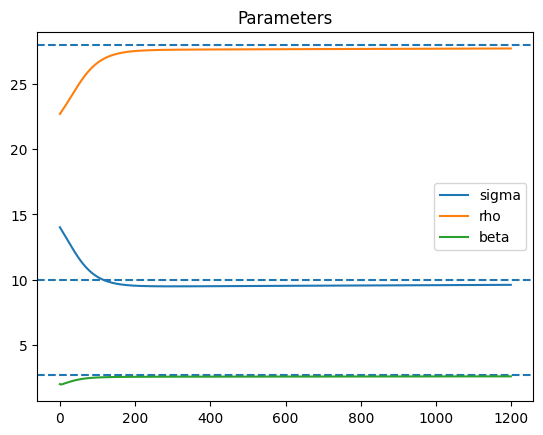

In [112]:
plot_params(h,true_params)

We can see that the loss is going down with considerable random scatter. Similarly, the parameters get closer and closer to their true values.

## How long can we integrate the model and still get useful gradients?

We can try integrating the models longer each learning step. Let's set the number of time steps to 100 and see what happens.

In [263]:
h = learning_loop(true_params, pert_params, 1e-2, 100, 300)

A Jupyter Widget

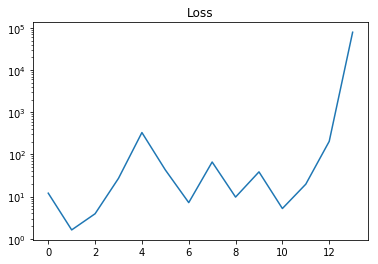

In [264]:
plt.plot(h['loss']); plt.yscale('log'); plt.title('Loss');

After around 13 learning steps we get NaNs. This suggests that the gradients are not stable.

Maybe we can reduce the learning rate to avoid these blow-ups.

In [272]:
h = learning_loop(true_params, pert_params, 1e-4, 75, 5000)

A Jupyter Widget

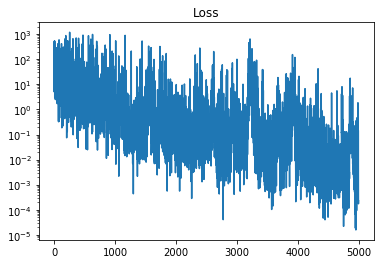

In [273]:
plt.plot(h['loss']); plt.yscale('log'); plt.title('Loss');

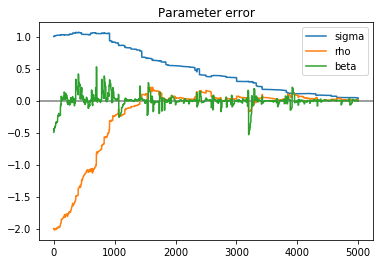

In [274]:
plot_params(h)

This seems to work. I tried to reduce the learning rate further and train for 100 steps, but no success. This suggests that there is some kind of limit.

## Sparse observations

Does this still work if we only have the truth for one of the three state variables? Let's take only $y$.

In [332]:
h = learning_loop(true_params, pert_params, 1e-3, 50, 2000, sparse=1)

A Jupyter Widget

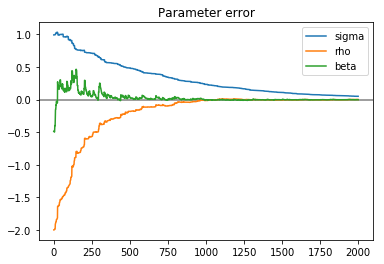

In [333]:
plot_params(h)

So it does still work, even though we have to tweak the learning rate again and train for longer. Larger learning rates blow up. This works for all three variables, but the sensitivity to the learning rate is different.

## Final thoughts

So what I set out to do seems to work in some way. Now what I am confused about is how interesting this is. Is this obvious and maybe just not practical for any kind of more complex model.

The computation of the gradient is possble for any kind of non-linear model which makes this so appealing to my mind. 

Don't be afraid to critique and ask dumb questions! I hope I made it clear that I don't really fully understand the problem myself, which means I am probably the dumb one :)